In [1]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import src.eda
from src.eda import one_hot_encode
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import gower
from sklearn.decomposition import PCA

In [3]:
df= pd.read_csv("../data/df_cleaned.csv")

In [4]:
df.head()

,listing_id,property_type,guest_capacity,location_score,review_score,amenities_count,host_response_time,season,cancellation_policy,nightly_rate,years_as_host_log,cleaning_fee_log,bedroom_encoded,min_stay_encoded
0,100822,Standard Apartment,4,75.17,4.87,8,within an hour,peak,flexible,187.29,0.955511,3.110399,1,1
1,100908,Standard Apartment,3,67.07,4.06,6,>24 hours,off-peak,flexible,255.64,1.629241,3.671225,1,1
2,101850,Standard Apartment,2,76.57,4.16,10,same day,off-peak,flexible,62.82,1.193922,3.938470,0,0
3,102385,Standard Apartment,2,88.14,3.74,11,same day,shoulder,strict,203.80,0.955511,3.593744,1,1
4,103827,Luxury Home,4,58.63,3.37,15,same day,peak,strict,1000.00,0.641854,4.563306,2,3


In [ ]:
df['log_nightly_rate'] = np.log1p(df['nightly_rate'])

In [7]:
gower_features = [
    'log_nightly_rate', 'guest_capacity', 'location_score', 'review_score',
    'amenities_count', 'bedroom_encoded',  
    'property_type', 'host_response_time', 'season', 'cancellation_policy'
]

df_gower = df[gower_features].copy()


In [ ]:
gower_dist = gower.gower_matrix(df_gower)

In [ ]:
agg = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')
df_gower["cluster"] = agg.fit_predict(gower_dist)

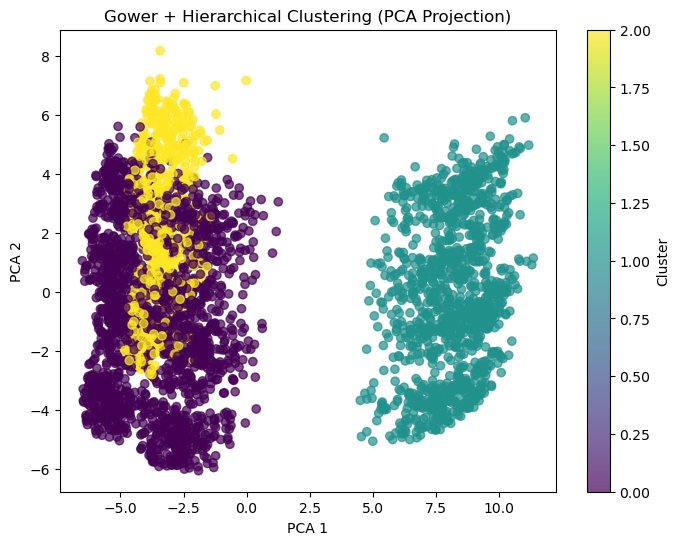

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(gower_dist)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_gower["cluster"], cmap='viridis', alpha=0.7)
plt.title("Gower + Hierarchical Clustering (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()

In [14]:
numeric_cols = df_gower.select_dtypes(include='number').columns

df_gower.groupby("cluster")[numeric_cols].mean().round(2)

,log_nightly_rate,guest_capacity,location_score,review_score,amenities_count,bedroom_encoded,cluster
cluster,,,,,,,
0,4.86,2.49,70.02,3.99,6.94,0.51,0.0
1,5.50,5.01,70.68,4.04,10.55,2.00,1.0
2,4.66,2.01,70.77,4.01,6.19,0.00,2.0


In [15]:
cat_cols = ["property_type", "host_response_time", "season", "cancellation_policy"]

for col in cat_cols:
    print(f"\n{col.upper()}：")
    display(df_gower.groupby("cluster")[col].value_counts(normalize=True).unstack().round(2))


PROPERTY_TYPE：


property_type,Luxury Home,Standard Apartment,Tiny Studio
cluster,,,
0,NaN,1.0,NaN
1,1.0,NaN,NaN
2,NaN,NaN,1.0



HOST_RESPONSE_TIME：


host_response_time,>24 hours,same day,within an hour
cluster,,,
0,0.09,0.41,0.50
1,0.11,0.39,0.50
2,0.10,0.41,0.48



SEASON：


season,off-peak,peak,shoulder
cluster,,,
0,0.29,0.41,0.30
1,0.31,0.38,0.31
2,0.29,0.42,0.28



CANCELLATION_POLICY：


cancellation_policy,flexible,moderate,strict
cluster,,,
0,0.51,0.28,0.21
1,0.49,0.29,0.22
2,0.49,0.28,0.23


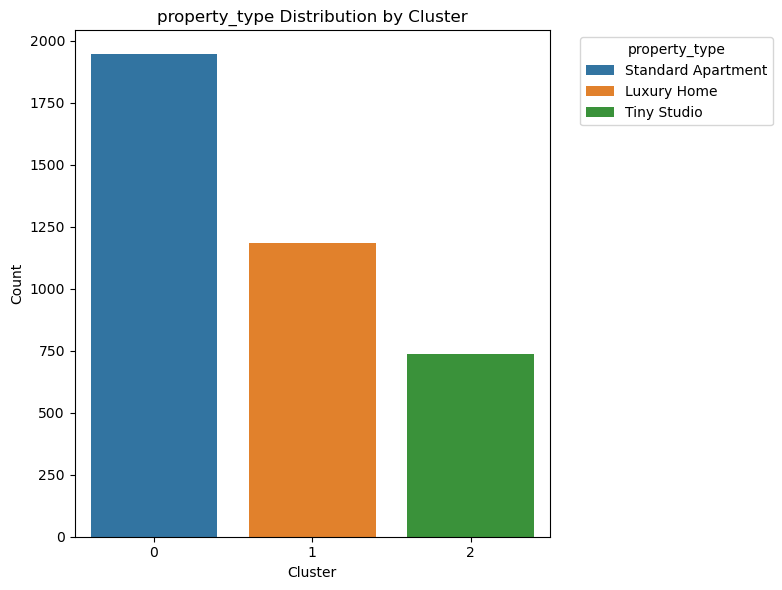

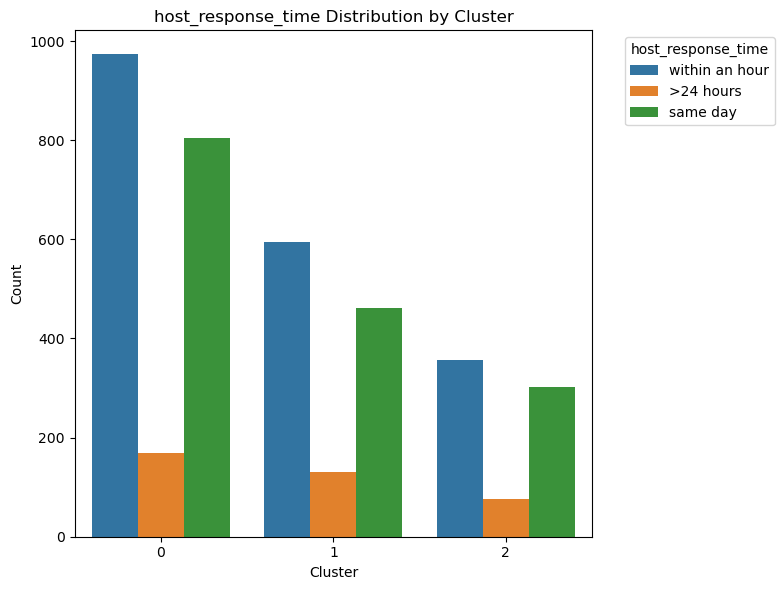

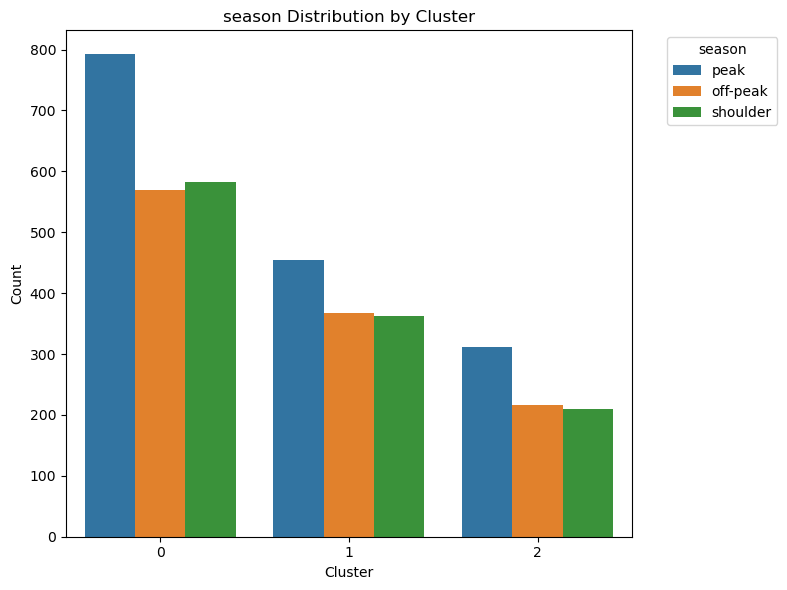

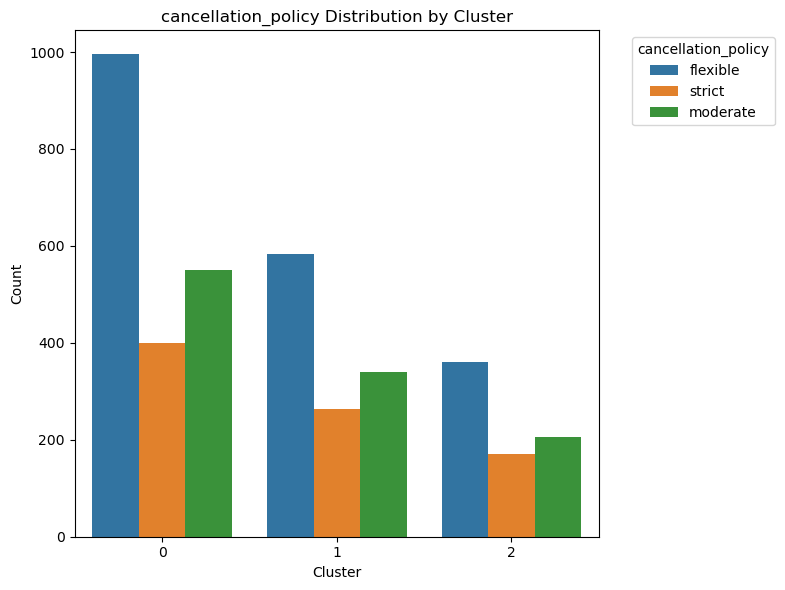

In [20]:
def plot_cluster_distributions(df, cluster_col, cat_cols):
    for cat_col in cat_cols:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=cluster_col, hue=cat_col, palette='tab10')
        plt.title(f'{cat_col} Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.legend(title=cat_col, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

categorical_features = ["property_type", "host_response_time", "season", "cancellation_policy"]

plot_cluster_distributions(df_gower, cluster_col="cluster", cat_cols=categorical_features)